# Korzystanie z wcześniej wytrenowanej konwolucyjnej sieci neuronowej

Korzystanie z uprzednio wytrenowanej sieci jest częstą praktyką uczenia głębokiego, która charakteryzuje się dużą skutecznością w przypadku uczenia się na małych zbiorach obrazów. Wytrenowana uprzednio sieć jest zapisaną siecią, która została wcześniej wytrenowana na dużym zbiorze danych (zwykle trenowanie to miało miejsce podczas wykonywania zadania klasyfikacji dużego zbioru obrazów). Jeżeli oryginalny zbiór danych był na tyle duży i na tyle ogólny, to przestrzenna hierarchia cech wyuczona przez wytrenowany wcześniej moduł może skutecznie odgrywać rolę ogólnego modelu przetwarzania obrazu — cechy tej sieci mogą przydawać się podczas rozwiązywania różnych problemów przetwarzania obrazu pomimo tego, że nowe problemy wymagają rozpoznawania zupełnie innych klas, niż miało to miejsce w przypadku oryginalnego zadania. Sieć może zostać wytrenowana np. na zbiorze ImageNet (klasami są w nim głównie zwierzęta i przedmioty codziennego użytku), a następnie użyta w celu wykonania zadania takiego jak identyfikacja mebli widocznych na zupełnie innych zdjęciach. Możliwość stosowania wytrenowanych sieci do rozwiązywania różnych problemów jest ogromną przewagą uczenia głębokiego nad starszymi algorytmami uczenia płytkiego. Dzięki tej technice uczenie głębokie może byś stosowane skutecznie w pracy z małymi zbiorami danych.

Chcemy skorzystać z dużej sieci konwolucyjnej wytrenowanej na zbiorze ImgeNet (1,4 miliona obrazów podzielonych na 1000 klas). Zbiór ImageNet obejmuje wiele klas zwierząt, w tym różne rasy psów i kotów, a więc wytrenowany na nim model prawdopodobnie sprawdzi się dobrze w przypadku problemu klasyfikacji zdjęć na zdjęcia psów i zdjęcia kotów.

Skorzystamy z architektury VGG16 opracowanej przez Karen Simonyan i Andrew Zissermana w 2014 r. To prosta i często stosowana architektura sieci uczących się na zbiorze ImageNet . Co prawda jest to dość stary model, który odbiega dość mocno od najnowszych i najbardziej zaawansowanych modeli, ale znamy już jego architekturę i jesteśmy w stanie zrozumieć jego działanie bez wprowadzania żadnych nowych koncepcji. W przyszłości z pewnością będziesz korzystać z modeli o nazwach pokroju VGG, ResNet, Inception, Inception-ResNet, Xception itd. Człony te występują w nazwach wielu architektur stosowanych w przetwarzaniu obrazu.

Istnieją dwie techniki stosowania wytrenowanej wcześniej sieci: ekstrakcja cech i dostrajanie. Opiszę oba rozwiązania, ale zacznę od ekstrakcji cech.

## Ekstrakcja cech

Ekstrakcja cech polega na korzystaniu z reprezentacji wyuczonej przez sieć wcześniej w celu dokonania ekstrakcji interesujących nas cech z nowych próbek. Cechy te są następnie przepuszczane przez nowy klasyfikator trenowany od podstaw.

Przypominam, że konwolucyjne sieci neuronowe stosowane w problemach klasyfikacji obrazów składają się z dwóch elementów serii warstw łączących (warstw pooling) i warstw konwolucyjnych. Na końcu sieci znajduje się gęsto połączony klasyfikator. Pierwsza część sieci określana jest mianem konwolucyjnej podstawy modelu. W przypadku sieci konwolucyjnej ekstrakcja cech polega na przyjrzeniu się konwolucyjnej podstawie wcześniej wytrenowanej sieci, przepuszczeniu przez nią nowych danych i wytrenowaniu nowego klasyfikatora na bazie wyjścia tej sieci:

![swapping FC classifiers](img\5_3a.png)

Dlaczego korzystamy ponownie tylko z konwolucyjnej bazy? Czy moglibyśmy skorzystać znów z gęsto połączonego klasyfikatora? Zwykle należy tego unikać. Wynika to z tego, że reprezentacje wyuczone przez konwolucyjną bazę są zwykle bardziej ogólne, a więc można z nich skorzystać również podczas pracy nad innym problemem: mapy cech konwolucyjnej sieci neuronowej przedstawiają ogólne koncepcje, które nadają się do rozwiązywania różnych problemów związanych z przetwarzaniem obrazu. Reprezentacje wyuczone przez klasyfikator są specyficzne dla danego zestawu klas, na których trenowano model — będą zawierać tylko informacje pozwalające na określenie prawdopodobieństwa tego, czy dana klasa jest widoczna na obrazie. Ponadto reprezentacje gęsto połączonych warstw nie zawierają żadnych informacji o miejscu umieszczenia rozpoznawanych obiektów na obrazie wejściowym — warstwy te nie polegają na przestrzeni, a informacje o położeniu obiektu znajdują się tylko w konwolucyjnej mapie cech. W przypadku problemów, w których położenie obiektu ma znaczenie praktyczne, gęsto połączone cechy są bezużyteczne.

Zauważ, że poziom ogólności (możliwości ponownego zastosowania) reprezentacji wyciągniętych przez określone warstwy konwolucyjne zależy od głębokości warstwy modelu. Warstwy występujące w modelu wcześniej dokonują ekstrakcji lokalnych wysoce ogólnych map cech (np. krawędzi, kolorów i tekstur), a warstwy wyższe dokonują ekstrakcji bardziej abstrakcyjnych koncepcji (rozpoznają np. „ucho kota” lub „oko psa”). Jeżeli nowy zbiór danych różni się bardzo od zbioru, na którym model był początkowo trenowany, to prawdopodobnie lepiej będzie, jak skorzystasz z kilku pierwszych warstw tego modelu w celu przeprowadzenia ekstrakcji cech i nie skorzystasz z całej konwolucyjnej bazy.

W naszym przypadku w zbiorze ImageNet wyodrębniono wiele klas zdjęć psów i kotów, a prawdopodobnie warto jest skorzystać z informacji umieszczonych w gęsto połączonych warstwach oryginalnego modelu, ale nie zrobimy tego w celu zaimplementowania bardziej ogólnego rozwiązania, w którym zestaw klas nowego problemu nie nakłada się na zestaw klas oryginalnego modelu. Zróbmy to w praktyce, korzystając z konwolucyjnej bazy sieci CGG16 wytrenowanej na zbiorze ImageNet w celu ekstrakcji cech ze zdjęć psów i kotów, a następnie wytrenujmy klasyfikator dzielący obrazy na zdjęcia psów i zdjęcia kotów.

Model VGG16 jest jednym z modeli dołączonych do pakietu Keras. Można go zaimportować z modułu keras.applications. Oto lista modeli klasyfikujących obrazy dostępnych w tym module (wszystkie te modele zostały wytrenowane na zbiorze ImageNet):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Utwórzmy instancję modelu VGG16.

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

2025-05-19 15:55:58.235780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 15:55:58.249651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747662958.262203   50256 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747662958.266237   50256 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 15:55:58.282814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Do konstruktora modelu przekazaliśmy trzy argumenty:

* Argument weights określa punkt kontrolny wag, z którego inicjowany jest model.
* Argument include_top określa to, czy do górnej części sieci dołączony zostanie gęsto połączony klasyfikator. Domyślnie klasyfikator ten odpowiada za 1000 klas zbioru ImageNet. Mamy zamiar korzystać z własnego klasyfikatora rozpoznającego dwie klasy (psy i koty), a więc nie chcemy dołączać wytrenowanego wcześniej klasyfikatora.
* Argument input_shape określa kształt tensorów obrazów, które będą kierowane do wejścia sieci. Argument ten nie musi być definiowany — jeżeli go nie określisz, to sieć będzie w stanie przetworzyć tensory wejściowe o dowolnym kształcie.

Oto szczegółowe informacje na temat architektury bazy konwolucyjnej modelu VGG16. Przypomina ona architekturę przedstawionych wcześniej prostych sieci konwolucyjnych:

In [2]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Finalna mapa cech ma kształt (4, 4, 512). Z tej mapy cech korzystać będzie klasyfikator.

Kolejne czynności możemy wykonywać na dwa sposoby:


* Możemy uruchomić konwolucyjną bazę na naszym zbiorze danych, zapisać wygenerowane przez nią wartości na dysku w postaci tablicy Numpy, a następnie użyć tej tablicy w charakterze danych wejściowych samodzielnego, gęsto połączonego klasyfikatora podobnego do tego, który został opisany w 1. części tej książki. Rozwiązanie to jest szybkie i łatwo je uruchomić, ponieważ wymaga tylko jednokrotnego uruchomienia konwolucyjnej bazy dla każdego obrazu wejściowego, a konwolucyjna baza jest najbardziej kosztownym obliczeniowo ogniwem potoku przetwarzania danych. Niestety wadą tego rozwiązania jest bark możliwości skorzystania z techniki augmentacji danych.
* Możemy rozszerzyć model, który posiadamy (conv_base), dodając do niego warstwy Dense i używając całej tej konstrukcji w celu przetworzenia danych wejściowych. Rozwiązanie to umożliwia korzystanie z augmentacji danych, ponieważ każdy obraz wejściowy przechodzi przez konwolucyjną bazę za każdym razem, gdy jest analizowany przez model. Niestety sprawia to, że technika ta wymaga przeprowadzania bardziej kosztownych obliczeń.

Opiszę oba rozwiązania. Na razie skupmy się na kodzie wymaganym w celu zaimplementowania pierwszego z nich — kodzie zapisującym dane wyjściowe bazy conv_base i pozwalającym na użycie ich w charakterze danych wejściowych nowego modelu.

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Generator zwraca dane w nieskończoność, a więc pętla musi zostać przerwana,
            # gdy każdy z obrazów zostanie przeanalizowany jednokrotnie.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


I0000 00:00:1747662962.544478   50472 service.cc:148] XLA service 0x7fd4c0015230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747662962.544665   50472 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-05-19 15:56:02.552994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747662962.586639   50472 cuda_dnn.cc:529] Loaded cuDNN version 90500


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


I0000 00:00:1747662964.931691   50472 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

Wyciągnięte cechy mają obecnie kształt (próbki, 4, 4, 512). Będziemy kierować je do gęsto połączonego klasyfikatora, a więc cechy musimy spłaszczyć do kształtu (próbki, 8192):

In [3]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Teraz możemy zdefiniować gęsto połączony klasyfikator (zwróć uwagę na zastosowanie techniki regularyzacji — porzucania) i wytrenować go na zapisanych przed chwilą danych i etykietach:

In [4]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


/SI/si/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.5842 - loss: 0.6853 - val_acc: 0.8220 - val_loss: 0.4589
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7603 - loss: 0.4709 - val_acc: 0.8560 - val_loss: 0.3782
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8289 - loss: 0.3898 - val_acc: 0.8730 - val_loss: 0.3355
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8739 - loss: 0.3234 - val_acc: 0.8790 - val_loss: 0.3122
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8921 - loss: 0.2821 - val_acc: 0.8830 - val_loss: 0.2951
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8970 - loss: 0.2570 - val_acc: 0.8840 - val_loss: 0.2834
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8944 - loss: 0.2621 - val_acc: 0.8830 - val_loss: 0.2816
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9190 - loss: 0.2382 - val_acc: 0.8940 - val_loss: 0.2680
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9039 -

Trenowanie przebiega bardzo szybko, ponieważ mamy tylko dwie warstwy Dense — przetworzenie epoki algorytmu zajmuje mniej niż sekundę nawet w przypadku korzystania z CPU.

Przeanalizujmy wykresy straty i dokładności trenowania:

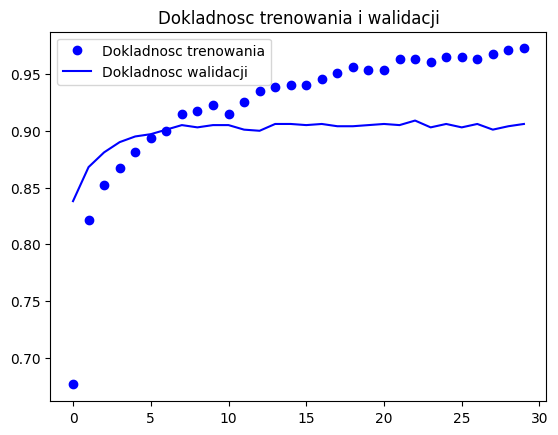

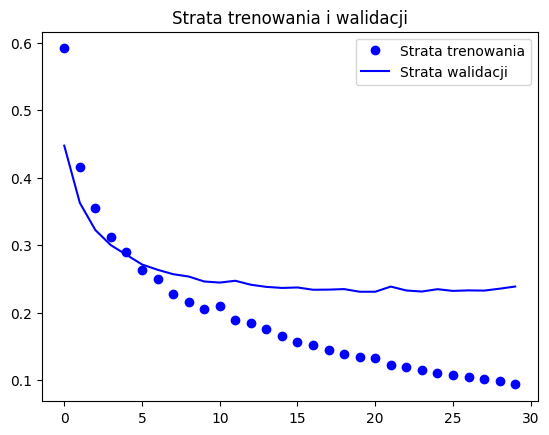

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()


Uzyskaliśmy dokładność na poziomie zbliżonym do 90% — to wynik o wiele lepszy od tego, który uzyskaliśmy w poprzednim podrozdziale, gdy trenowaliśmy model od podstaw. Z wykresów wynika jednak również to, że model niemalże od początku ulega nadmiernemu dopasowaniu pomimo przyjęcia dość dużej wartości współczynnika odrzutu. Wynika to z tego, że nie korzystamy z techniki augmentacji danych, która jest niezbędna, by zapobiegnąć przeuczeniu modelu podczas przetwarzania małych zbiorów obrazów.

Teraz przyjrzyjmy się drugiej technice ekstrakcji cech, która jest o wiele wolniejsza i wymaga wykonywania o wiele bardziej skomplikowanych obliczeń, ale umożliwia korzystanie z augmentacji danych podczas trenowania — dokonamy rozbudowy modelu conv_base i przetworzymy dane od początku do końca przy użyciu tego właśnie modelu.

Modele mają właściwości warstw, a więc model conv_base może zostać dodany do modelu sekwencyjnego (Sequential), tak jakbyśmy łączyli ze sobą kolejne warstwy sieci.

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Teraz nasz model charakteryzuje się następującą budową:

In [11]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

Konwolucyjna baza sieci VGG16 ma 14 714 688 parametrów (jest to bardzo duża liczba). Klasyfikator dodawany do tej bazy ma 2 miliony parametrów.

Zanim skompilujemy i wytrenujemy model, musimy zamrozić bazę konwolucyjną. Zamrażanie warstwy lub zestawu warstw polega na zapobieganiu aktualizacji ich wag w procesie trenowania. Jeżeli tego nie zrobimy, to reprezentacje wyuczone wcześniej przez bazę konwolucyjną zostaną zmodyfikowane podczas trenowania. Warstwy Dense znajdujące się u góry są inicjowane w sposób losowy, co sprawia, że dochodziłoby do dużych zmian wszystkich parametrów sieci, co skutecznie zniszczyłoby wyuczone wcześniej reprezentacje.

W pakiecie Keras sieć zamraża się, przypisując wartość False atrybutowi trainable:

In [12]:
print('Liczba wag poddawanych trenowaniu '
      'przed zamrożeniem bazy:', len(model.trainable_weights))

Liczba wag poddawanych trenowaniu przed zamrożeniem bazy: 30


In [6]:
conv_base.trainable = False

In [ ]:
print('Liczba wag poddawanych trenowaniu '
      'po zamrożeniu bazy:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


Przy takiej konfiguracji trenowane będą tylko wagi z dwóch warstw Dense. Będą to w sumie cztery tensory wag: po dwa tensory na warstwę (główna macierz wag i wektor wartości progowych). Pamiętaj o tym, że w celu wprowadzenia zmian należy najpierw skompilować model. Jeżeli zmienisz możliwość trenowania wag po skompilowaniu modelu, musisz go skompilować jeszcze raz, w przeciwnym razie wprowadzone zmiany zostaną zignorowane.

Teraz możemy rozpocząć trenowanie modelu przy takiej samej konfiguracji techniki augmentacji danych, z jakiej korzystaliśmy w poprzednim przykładzie.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Pamiętaj o tym, że dane walidacyjne nie mogą być modyfikowane!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Katalog docelowy.
        train_dir,
        # Rozdzielczość wszystkich obrazów zostanie zmieniona na 150x150.
        target_size=(150, 150),
        batch_size=20,
        # Korzystamy z funkcji straty w postaci binarnej entropii krzyżowej, a więc potrzebujemy etykiet w formie binarnej.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/SI/si/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/SI/si/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 9s - 87ms/step - acc: 0.6970 - loss: 0.5821 - val_acc: 0.8200 - val_loss: 0.4408
Epoch 2/30
100/100 - 7s - 67ms/step - acc: 0.7840 - loss: 0.4820 - val_acc: 0.8600 - val_loss: 0.3640
Epoch 3/30
100/100 - 7s - 68ms/step - acc: 0.8105 - loss: 0.4262 - val_acc: 0.8830 - val_loss: 0.3230
Epoch 4/30
100/100 - 7s - 67ms/step - acc: 0.8160 - loss: 0.3992 - val_acc: 0.8780 - val_loss: 0.3162
Epoch 5/30
100/100 - 7s - 68ms/step - acc: 0.8365 - loss: 0.3784 - val_acc: 0.8940 - val_loss: 0.2918
Epoch 6/30
100/100 - 7s - 68ms/step - acc: 0.8415 - loss: 0.3671 - val_acc: 0.8860 - val_loss: 0.2870
Epoch 7/30
100/100 - 7s - 68ms/step - acc: 0.8470 - loss: 0.3610 - val_acc: 0.8910 - val_loss: 0.2805
Epoch 8/30
100/100 - 7s - 68ms/step - acc: 0.8505 - loss: 0.3490 - val_acc: 0.8870 - val_loss: 0.2780
Epoch 9/30
100/100 - 7s - 69ms/step - acc: 0.8625 - loss: 0.3317 - val_acc: 0.8870 - val_loss: 0.2721
Epoch 10/30
100/100 - 7s - 69ms/step - acc: 0.8495 - loss: 0.3298 - val_acc: 0.8850 - val_los

In [8]:
model.save('cats_and_dogs_small_3.keras')

Ponownie przedstawmy wyniki pracy algorytmu na wykresach:

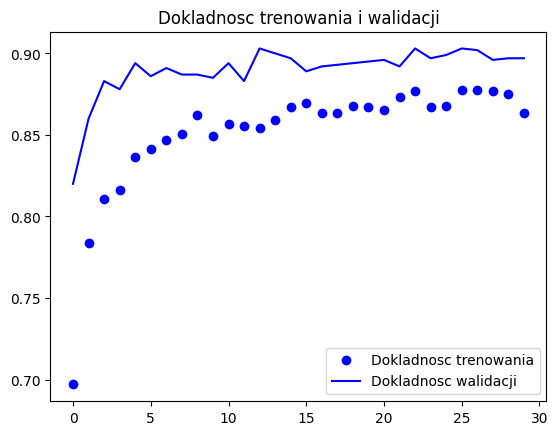

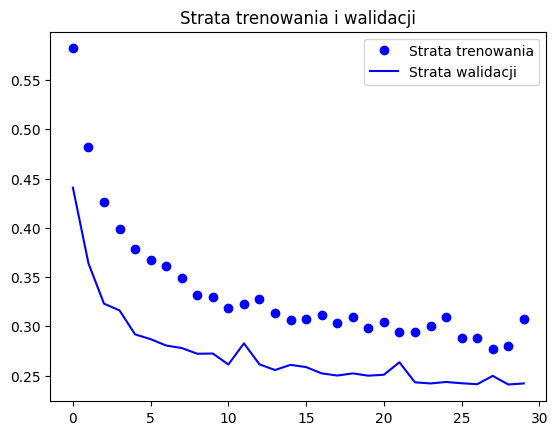

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Jak widać, uzyskaliśmy dokładność walidacji sięgającą około 96%. To o wiele lepszy wynik od tego, który uzyskaliśmy przy użyciu małej sieci konwolucyjnej trenowanej od podstaw.

## Dostrajanie

Dostrajanie jest techniką ponownego stosowania modeli uzupełniającą ekstrakcję cech. Polega ona na odmrażaniu kilku górnych warstw zamrożonej bazy modelu używanej do ekstrakcji cech i trenowanie jej łącznie z nową częścią modelu (w naszym przypadku tą częścią modelu jest w pełni połączony klasyfikator). Proces ten określamy mianem dostrajania, ponieważ modyfikuje on częściowo wytrenowane wcześniej bardziej abstrakcyjne reprezentacje modelu w celu dostosowania ich do bieżącego problemu.

![fine-tuning VGG16](img\5_3b.png)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Pamiętaj o tym, że dane walidacyjne nie mogą być modyfikowane!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Katalog docelowy.
        train_dir,
        # Rozdzielczość wszystkich obrazów zostanie zmieniona na 150x150.
        target_size=(150, 150),
        batch_size=20,
        # Korzystamy z funkcji straty w postaci binarnej entropii krzyżowej, a więc potrzebujemy etykiet w formie binarnej.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
model = models.load_model('cats_and_dogs_small_3.keras')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Stwierdziłem, że musimy zamrozić bazę konwolucji modelu VGG16 aby wytrenować losowo zainicjowany klasyfikator kończący sieć. Z tego samego powodu możliwe jest tylko dostrajanie górnych warstw konwolucyjnej bazy po wytrenowaniu klasyfikatora. Jeżeli klasyfikator nie byłby jeszcze wytrenowany, to sygnał błędu przepływający przez sieć w trakcie trenowania byłby zbyt duży i doprowadziłby do zniszczenia reprezentacji wyuczonych wcześniej przez dostrajane warstwy. W związku z tym dostrajanie sieci należy przeprowadzać w następujący sposób:

* 1) Dodaj samodzielnie zaprojektowaną sieć do końca bazy wytrenowanego już modelu.
* 2) Zamróź bazę sieci.
* 3) Wytrenuj nową część sieci.
* 4) Odmroź niektóre warstwy bazy sieci.
* 5) Wytrenuj razem te warstwy oraz nową część sieci.

Pierwsze trzy kroki wykonaliśmy podczas ekstrakcji cech. Zajmijmy się krokiem 4. Odmrozimy bazę conv_base, a następnie zamrozimy jej wybrane warstwy.

Przypominam, że nasza sieć charakteryzuje się następującą architekturą:

In [6]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)


Dostroimy ostatnie trzy warstwy konwolucyjne, a więc wszystkie warstwy aż do warstwy block4_pool powinny zostać zamrożone, a warstwy block5_conv1, block5_conv2 i block5_conv3 powinny dawać się trenować.

Dlaczego nie będziemy dostrajać większej liczby warstw? Dlaczego nie dostroić całej bazy konwolucyjnej? Moglibyśmy to zrobić, ale musimy pamiętać o następujących rzeczach:


* Wcześniejsze warstwy bazy konwolucyjnej kodują bardziej ogólne, uniwersalne cechy, a wyższe warstwy kodują bardziej wyspecjalizowane cechy. Lepiej jest dostrajać bardziej wyspecjalizowane cechy, ponieważ to od nich zależy przydatność modelu w nowym zastosowaniu. Podczas dostrajania niższych warstw dochodziłoby do szybkiego spadku zwracanych wartości.
* Im więcej parametrów jest trenowanych, tym większe jest ryzyko nadmiernego dopasowania. Baza konwolucyjna ma 15 milionów parametrów, a trenowanie tak dużej liczby parametrów na niewielkim zbiorze danych, którym dysponujemy, byłoby ryzykowne.

W związku z tym w naszym przypadku dobrą strategią jest dostrajanie tylko dwóch lub trzech górnych warstw bazy konwolucyjnej. Zróbmy to, zaczynając od miejsca, w którym skończyliśmy w poprzednim przykładzie.

In [7]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Teraz możemy rozpocząć dostrajanie sieci. Zrobimy to za pomocą algorytmu optymalizującego RMSProp przy bardzo niskiej wartości parametru uczenia. Wybranie niskiej wartości wynika z tego, że chcemy minimalizować modyfikacje reprezentacji trzech dostrajanych warstw. Zbyt duże zmiany tych wartości mogłyby zaszkodzić reprezentacjom danych.

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100


/SI/si/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc: 0.8671 - loss: 0.3006

/SI/si/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - acc: 0.8671 - loss: 0.3006 - val_acc: 0.8990 - val_loss: 0.2416
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - acc: 0.8607 - loss: 0.2927 - val_acc: 0.9010 - val_loss: 0.2413
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - acc: 0.8830 - loss: 0.2709 - val_acc: 0.9010 - val_loss: 0.2435
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - acc: 0.8896 - loss: 0.2692 - val_acc: 0.8950 - val_loss: 0.2577
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - acc: 0.8895 - loss: 0.2630 - val_acc: 0.8950 - val_loss: 0.2526
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - acc: 0.8810 - loss: 0.2710 - val_acc: 0.8980 - val_loss: 0.2408
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - acc: 0.8862 - loss: 0.2632 - val_acc: 0.9000 - val_loss: 0.2400
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - acc: 0.8832 - loss: 0.2645 - val_acc: 0.9000 - val_loss: 0.2464
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/ste

In [12]:
model.save('cats_and_dogs_small_4.keras')

Wygenerujmy wykresy, korzystając z napisanego wcześniej kodu:

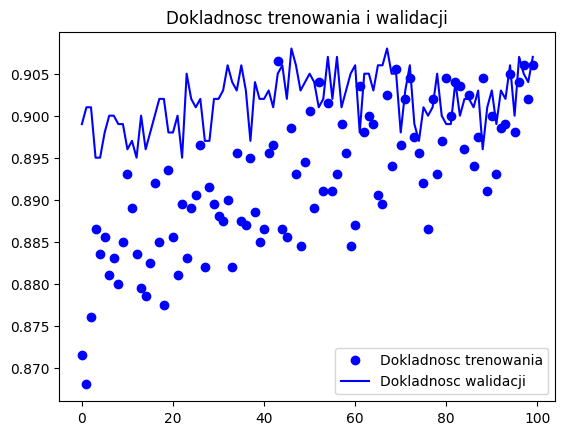

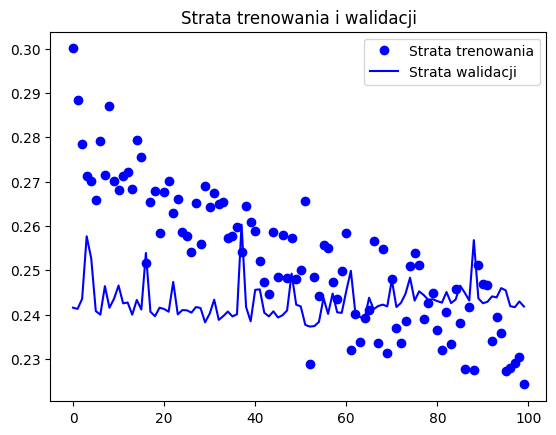

In [10]:
from matplotlib import pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()


Krzywe te wyglądają dość chaotycznie. W celu zwiększenia ich czytelności możemy je wygładzić zastępując poszczególne wartości straty i dokładności wykładniczą średnią ruchomą tych parametrów. Oto prosta funkcja pomocnicza, która pozwoli na wygenerowanie bardziej czytelnych wykresów:

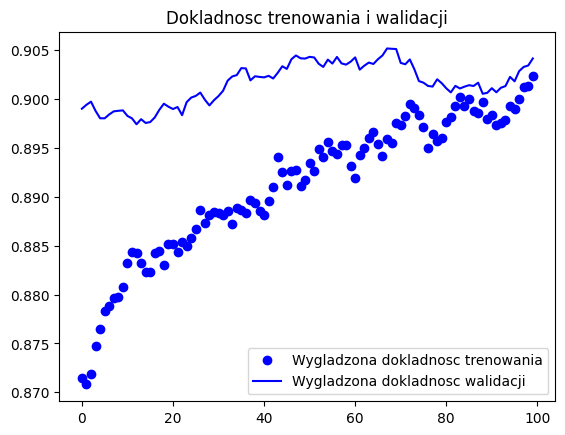

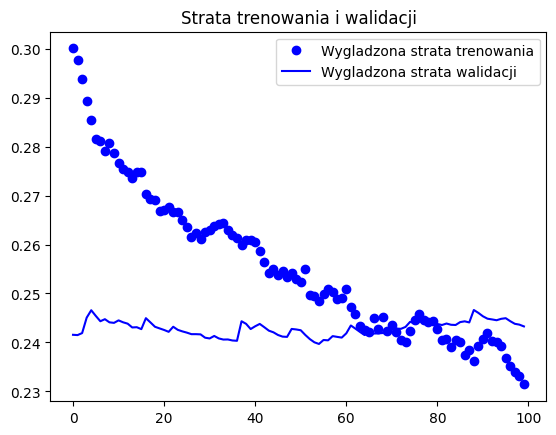

In [13]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Wygladzona dokladnosc trenowania')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Wygladzona dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Wygladzona strata trenowania')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Wygladzona strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Krzywa dokładności walidacji wygląda wyraźniej. Widać ładny 1-procentowy bezwzględny wzrost dokładności (z 96% na ponad 97%).

Zauważ, że krzywa straty nie wykazuje żadnej realnej poprawy (tak naprawdę wynika z niej pogorszenie parametru pracy modelu). Dlaczego dokładność jest stabilna, a nawet poprawiła się, jeżeli wartości straty nie spadają? Odpowiedź jest prosta: widzimy średnią punktowych wartości straty, a dokładność zależy od rozkładu wartości straty (nie ich średniej). Dzieje się tak, ponieważ dokładność jest binarną wartością progową prawdopodobieństwa klas przewidywanych przez model. Model może działać lepiej pomimo tego, że nie odzwierciedlają tego średnie wartości straty.


Na koniec możemy sprawdzić działanie modelu na danych testowych:

In [15]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('dokładnosc podczas testowania:', test_acc)

Found 1000 images belonging to 2 classes.


/SI/si/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.9177 - loss: 0.2135
dokładnosc podczas testowania: 0.9079999923706055



Uzyskamy testową dokładność na poziomie 97%. Gdybyśmy wzięli udział w konkursie Kaggle dotyczącym tego zbioru danych, to uzyskalibyśmy jeden z najwyższych wyników. Dzięki nowoczesnym technikom uczenia głębokiego udało nam się uzyskać taki wynik, dysponując tylko niewielką częścią treningowego zbioru danych (około 10% danych). Możliwość trenowania modelu na zbiorze 20 000 próbek to coś zupełnie innego niż trenowanie modelu na 2000 próbek

## Wnioski

Oto wnioski, które należy wynieść z dwóch ostatnich podrozdziałów:

* Konwolucyjne sieci neuronowe są najlepszymi modelami uczenia maszynowego do zadań związanych z przetwarzaniem obrazu. Można je trenować od podstaw nawet na małych zbiorach danych i uzyskiwać przy tym sensowne wyniki.
* Głównym problemem podczas pracy z małymi zbiorami danych jest nadmierne dopasowanie modelu. Problem ten podczas pracy z danymi będącymi obrazami można rozwiązać za pomocą techniki augmentacji danych.
* Ekstrakcja cech umożliwia łatwe użycie utworzonej wcześniej konwolucyjnej sieci neuronowej w celu rozwiązania nowego problemu. Technika ta jest szczególnie przydatna podczas pracy z małymi zbiorami obrazów.
* Efekty ekstrakcji cech można wzmocnić techniką dostrajania, która polega na przystosowywaniu wyuczonej wcześniej reprezentacji danych do nowego problemu. Zabieg ten zwiększa nieco skuteczność pracy modelu.

Teraz dysponujesz już solidnym zestawem narzędzi przeznaczonych do rozwiązywania problemów klasyfikacji obrazów, które to narzędzia sprawdzają się szczególnie dobrze podczas pracy z małymi zbiorami danych.